In [ ]:
!pip install facenet-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.1 MB/s eta 0:00:00


In [ ]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from fastai.losses import CrossEntropyLossFlat

In [ ]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class TungHX(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        super(TungHX, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchsummary import summary
model_rs = TungHX(Bottleneck, [3, 4, 6, 3]).cuda()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model_rs, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)
# Load trọng số của ResNet50 vào model
model_rs.load_state_dict(resnet50.state_dict(), strict=False)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
print(model_rs)

TungHX(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
!unzip /content/drive/MyDrive/data/fake_6.zip

Archive:  /content/drive/MyDrive/data/fake_6.zip
  inflating: fake_6/325211.jpg       
  inflating: fake_6/325361.jpg       
  inflating: fake_6/325394.jpg       
  inflating: fake_6/325438.jpg       
  inflating: fake_6/325509.jpg       
  inflating: fake_6/325571.jpg       
  inflating: fake_6/325647.jpg       
  inflating: fake_6/325672.jpg       
  inflating: fake_6/325723.jpg       
  inflating: fake_6/325785.jpg       
  inflating: fake_6/325807.jpg       
  inflating: fake_6/325824.jpg       
  inflating: fake_6/325871.jpg       
  inflating: fake_6/326050.jpg       
  inflating: fake_6/326175.jpg       
  inflating: fake_6/326249.jpg       
  inflating: fake_6/326321.jpg       
  inflating: fake_6/326670.jpg       
  inflating: fake_6/326849.jpg       
  inflating: fake_6/326854.jpg       
  inflating: fake_6/326862.jpg       
  inflating: fake_6/326915.jpg       
  inflating: fake_6/326973.jpg       
  inflating: fake_6/326981.jpg       
  inflating: fake_6/326983.jpg       
 

In [ ]:
!unrar x /content/drive/MyDrive/data/resize1.rar



UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/drive/MyDrive/data/resize1.rar

Creating    resize1                                                   OK
Extracting  resize1/real_1.jpg                                             0%  OK 
Extracting  resize1/real_10.jpg                                            0%  OK 
Extracting  resize1/real_100.jpg                                           1%  OK 
Extracting  resize1/real_101.jpg                                           1%  OK 
Extracting  resize1/real_102.jpg                                           2%  OK 
Extracting  resize1/real_103.jpg                                           2%  OK 
Extracting  resize1/real_104.jpg                                           2%  OK 
Extracting  resize1/real_105.jpg                                           3%  OK 
Extracting  resize1/real_106.jpg                          

In [ ]:
!zip -r /content/drive/MyDrive/data/Data_full.zip /content/Data_r

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  adding: content/Data_r/real_r/realq_33.png (deflated 1%)
  adding: content/Data_r/real_r/realq_313.png (deflated 0%)
  adding: content/Data_r/real_r/realq_7242.png (deflated 1%)
  adding: content/Data_r/real_r/realq_649.png (deflated 0%)
  adding: content/Data_r/real_r/realq_8533.png (deflated 0%)
  adding: content/Data_r/real_r/realq_245.png (deflated 0%)
  adding: content/Data_r/real_r/realq_8573.png (deflated 0%)
  adding: content/Data_r/real_r/realq_3315.png (deflated 0%)
  adding: content/Data_r/real_r/realq_7930.png (deflated 0%)
  adding: content/Data_r/real_r/realq_10353.png (deflated 1%)
  adding: content/Data_r/real_r/realq_11184.png (deflated 0%)
  adding: content/Data_r/real_r/realq_2647.png (deflated 1%)
  adding: content/Data_r/real_r/realq_5400.png (deflated 0%)
  adding: content/Data_r/real_r/realq_8132.png (deflated 0%)
  adding: content/Data_r/real_r/realq_7871.png (deflated 1%)
  adding: content/Data_r/real_r

In [ ]:
from PIL import Image
import os

# Đường dẫn đến thư mục chứa các tệp JPEG
jpeg_dir = "/content/resize1"

# Đường dẫn đến thư mục chứa các tệp PNG kết quả
png_dir = "/content/real_M"

# Lặp qua các tệp trong thư mục JPEG
for filename in os.listdir(jpeg_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Đường dẫn đến tệp ảnh JPEG
        jpeg_file = os.path.join(jpeg_dir, filename)
        
        # Tạo đường dẫn đến tệp ảnh PNG kết quả
        png_file = os.path.join(png_dir, os.path.splitext(filename)[0] + ".png")
        
        # Đọc tệp JPEG và lưu sang tệp PNG
        img = Image.open(jpeg_file)
        img.save(png_file, "png")
        
        # Xóa tệp JPEG nếu muốn
        os.remove(jpeg_file)

In [ ]:

import os

# Đường dẫn đến thư mục
dir_path = '/content/Data_r/fake_r'

# Định dạng ảnh được hỗ trợ
image_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Đếm số lượng tệp ảnh trong thư mục
image_count = 0
for file_name in os.listdir(dir_path):
    if file_name.lower().endswith(image_formats):
        image_count += 1

# In số lượng tệp ảnh trong thư mục
print(f"Số lượng tệp ảnh trong thư mục '{dir_path}' là {image_count}.")

Số lượng tệp ảnh trong thư mục '/content/Data_r/fake_r' là 12258.


In [ ]:
import os

# Đường dẫn đến thư mục chứa các tệp ảnh cần đổi tên
folder_path = '/content/Data_r/fake_r'

# Đổi tên tất cả các tệp ảnh trong thư mục
count = 0
for filename in os.listdir(folder_path):
    # Kiểm tra tệp có phải là ảnh hay không (PNG hoặc JPG)
    if filename.endswith('.png') or filename.endswith('.JPG'):
        # Tạo tên mới cho tệp
        new_filename = f'fakeq_{count+1}{os.path.splitext(filename)[1]}'
        
        # Đường dẫn đầy đủ đến tệp cũ và tệp mới
        src_path = os.path.join(folder_path, filename)
        dest_path = os.path.join(folder_path, new_filename)
        
        # Đổi tên tệp
        os.rename(src_path, dest_path)
        
        # Tăng biến đếm
        count += 1

In [ ]:
import os
import shutil

# Đường dẫn đến thư mục chứa các tệp ảnh ban đầu
source_folder = '/content/fake_6'

# Đường dẫn đến thư mục mới để chứa các tệp ảnh đã được di chuyển
destination_folder = '/content/Data_r/fake_r'

# Lặp qua từng tệp trong thư mục nguồn
for filename in os.listdir(source_folder):
    # Đường dẫn đầy đủ đến tệp gốc và tệp mới
    src_path = os.path.join(source_folder, filename)
    dest_path = os.path.join(destination_folder, filename)
    
    # Di chuyển tệp đến thư mục đích
    shutil.move(src_path, dest_path)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, df, transforms, num_classes = 2):
        self.df = df
        self.transforms = transforms
        self.num_classes = num_classes
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = self.df.iloc[idx]["label"]
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        # Chuyển đổi label thành dạng one-hot
        one_hot_label = torch.zeros(self.num_classes)
        one_hot_label[label] = 1
        return img, one_hot_label
import os
import pandas as pd
import numpy as np

data_dir = "/content/Data_r"

real_images = []
fake_images = []

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        if folder_name == "real_r":
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                real_images.append((img_path, 1))
        elif folder_name == "fake_r":
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                fake_images.append((img_path, 0))

# shuffle the images and labels
np.random.shuffle(real_images)
np.random.shuffle(fake_images)

# Create the data frame with two columns
images = pd.DataFrame(real_images + fake_images, columns=["image_path", "label"])
# Trộn dữ liệu và chia thành các tập huấn luyện, validation và kiểm tra
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(images, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

batch_size = 16
images.head(-5)

,image_path,label
0,/content/Data_r/real_r/realq_3549.png,1
1,/content/Data_r/real_r/eye00104.jpg,1
2,/content/Data_r/real_r/realq_10508.png,1
3,/content/Data_r/real_r/realq_4226.png,1
4,/content/Data_r/real_r/realq_2756.png,1
...,...,...
24821,/content/Data_r/fake_r/037838.jpg,0
24822,/content/Data_r/fake_r/fakeq_4737.png,0
24823,/content/Data_r/fake_r/fakeq_5607.png,0
24824,/content/Data_r/fake_r/fakeq_1629.png,0


In [ ]:

import torch

def to_category(label, num_classes=2):
    """Chuyển đổi label thành dạng one-hot vector."""
    category = torch.zeros(num_classes)
    category[label] = 1
    return category

# Tạo một mảng 2D (N x 2) dựa trên giá trị nhãn của tập huấn luyện
train_labels = train_data["label"].values
train_labels_one_hot = torch.stack([to_category(label) for label in train_labels])

# Tạo một mảng 2D (N x 2) dựa trên giá trị nhãn của tập validation
val_labels = val_data["label"].values
val_labels_one_hot = torch.stack([to_category(label) for label in val_labels])

# Tạo một mảng 2D (N x 2) dựa trên giá trị nhãn của tập kiểm tra
test_labels = test_data["label"].values
test_labels_one_hot = torch.stack([to_category(label) for label in test_labels])

In [ ]:


print(len(val_data))

729


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.RandomHorizontalFlip(),
transforms.RandomRotation(20),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None, num_classes=2):
        self.data = data
        self.transform = transform
        self.num_classes = num_classes
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.data.iloc[idx]["label"]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor([1, 0]) if label == 0 else torch.tensor([0, 1])
        
        return img, label


In [ ]:
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=val_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)
print(len(train_dataset))

17381


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(len(train_loader))

1087


In [ ]:
print(model_rs.parameters)

<bound method Module.parameters of TungHX(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [ ]:
%ls /content/Data_r


fake_r/  real_r/


In [ ]:
import os
import shutil

# Đường dẫn đến thư mục chứa các thư mục con cần xóa .ipynb_checkpoints
dir_path = "/content/Data_r"

# Duyệt qua các thư mục con của thư mục dir_path và xóa thư mục .ipynb_checkpoints
for root, dirs, files in os.walk(dir_path):
    for dir in dirs:
        if dir == ".ipynb_checkpoints":
            dir_to_delete = os.path.join(root, dir)
            shutil.rmtree(dir_to_delete)

loss number does not decrease =>  0.002
Epoch [1/15], Train Loss: 0.4322, Val Loss: 0.4848, Train Acc: 0.8292, Val Acc: 0.8250


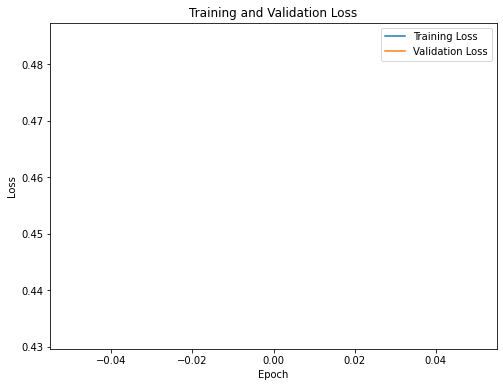

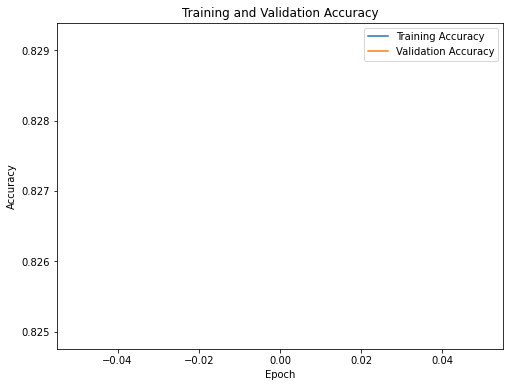

loss number does not decrease =>  0.002
Epoch [2/15], Train Loss: 0.4008, Val Loss: 0.6845, Train Acc: 0.8498, Val Acc: 0.8456


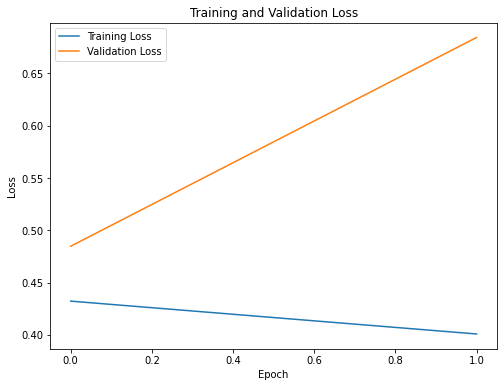

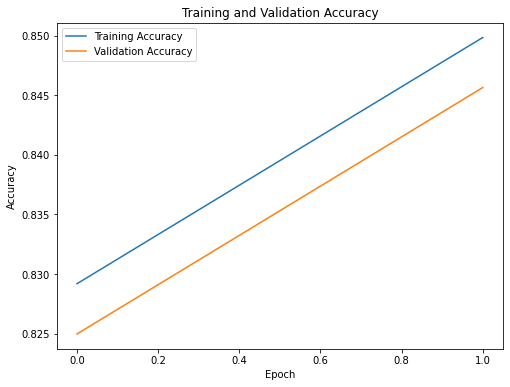

loss number does not decrease =>  0.002
Epoch [3/15], Train Loss: 0.3491, Val Loss: 0.3881, Train Acc: 0.8655, Val Acc: 0.8311


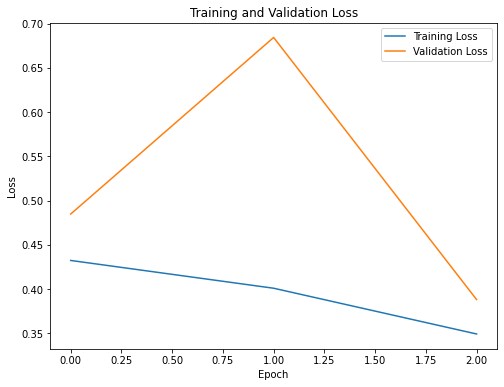

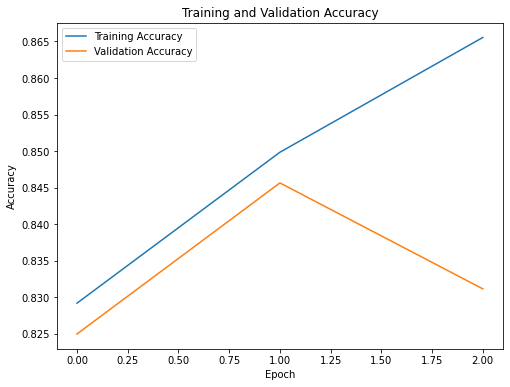

loss number does not decrease =>  0.002
Epoch [4/15], Train Loss: 0.3431, Val Loss: 0.3643, Train Acc: 0.8671, Val Acc: 0.8456


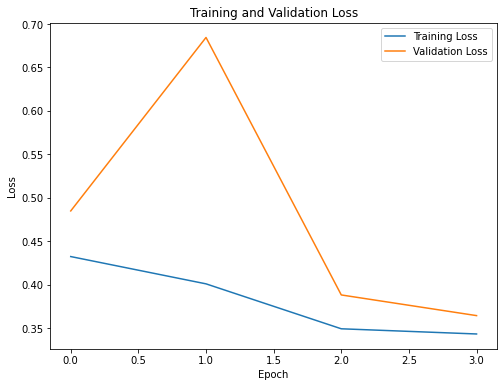

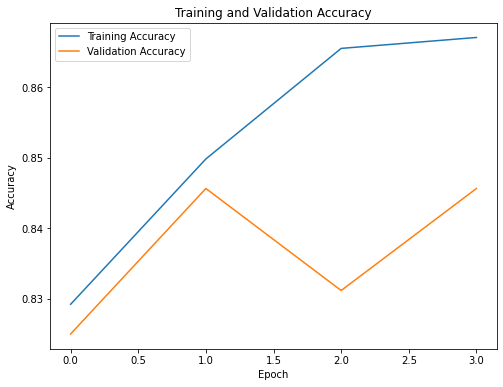

loss number does not decrease =>  0.002
Epoch [5/15], Train Loss: 0.3402, Val Loss: 0.2764, Train Acc: 0.8724, Val Acc: 0.8910


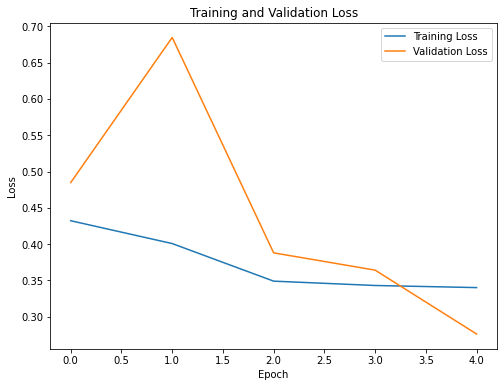

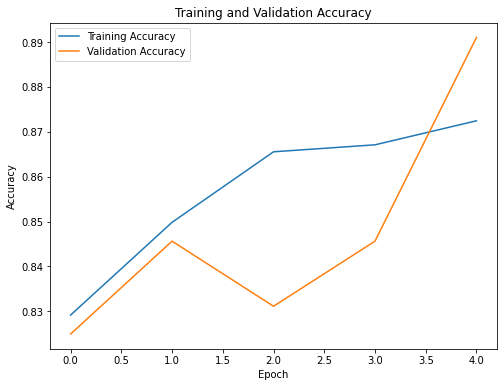

loss number does not decrease =>  0.002
Epoch [6/15], Train Loss: 0.3299, Val Loss: 0.3353, Train Acc: 0.8779, Val Acc: 0.8937


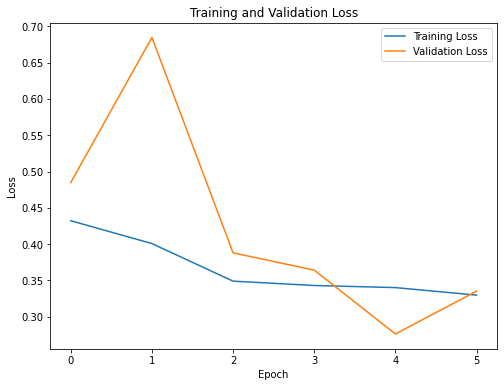

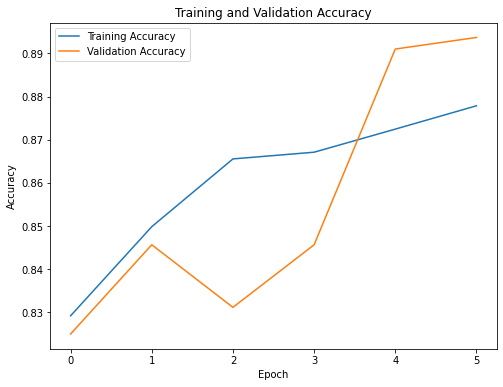

Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
loss number does not decrease =>  0.0002
Epoch [7/15], Train Loss: 0.3462, Val Loss: 0.3685, Train Acc: 0.8842, Val Acc: 0.8580


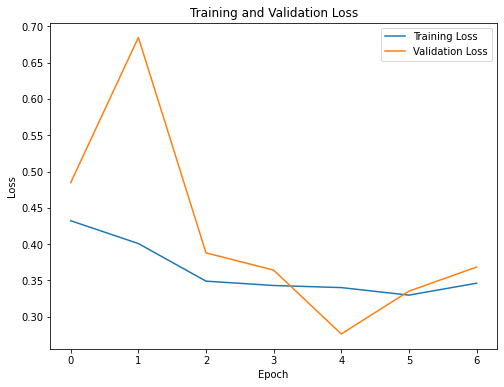

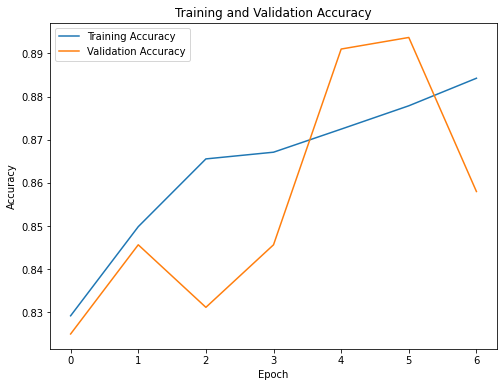

loss number does not decrease =>  0.0002
Epoch [8/15], Train Loss: 0.3072, Val Loss: 0.2644, Train Acc: 0.8887, Val Acc: 0.9031


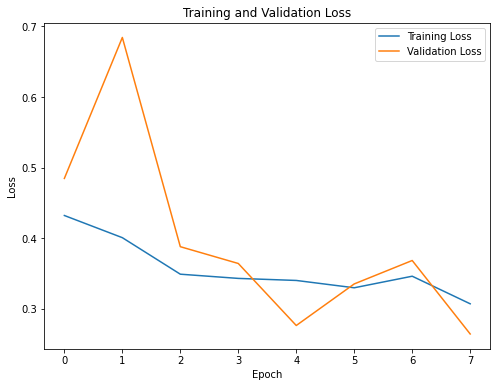

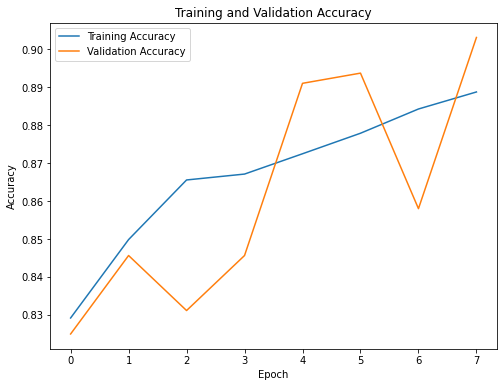

loss number does not decrease =>  0.0002
Epoch [9/15], Train Loss: 0.2885, Val Loss: 0.2848, Train Acc: 0.8947, Val Acc: 0.8969


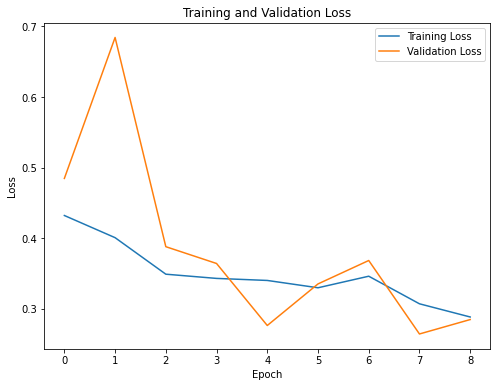

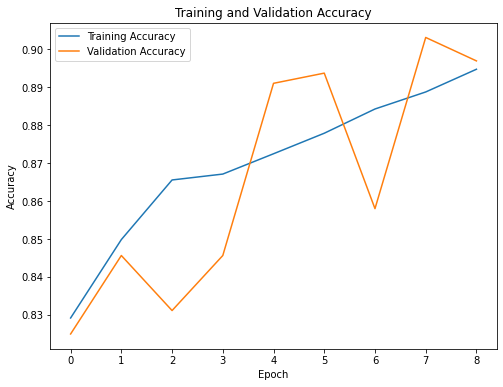

loss number does not decrease =>  0.0002
Epoch [10/15], Train Loss: 0.2781, Val Loss: 0.2786, Train Acc: 0.8968, Val Acc: 0.8902


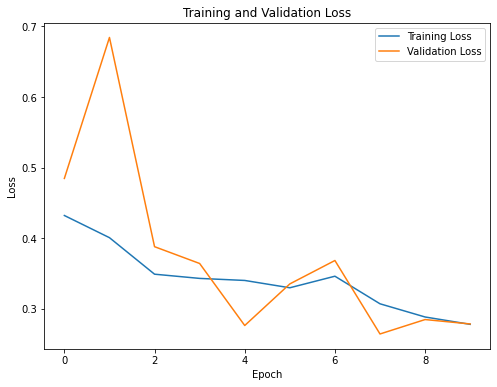

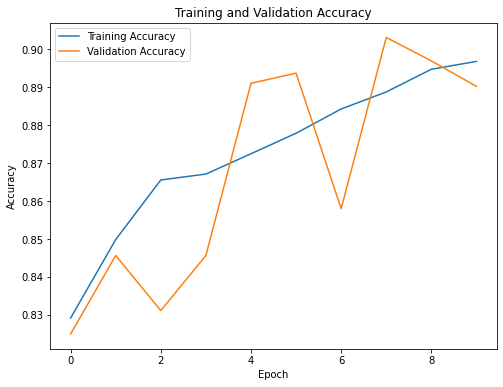

loss number does not decrease =>  0.0002
Epoch [11/15], Train Loss: 0.2761, Val Loss: 0.2770, Train Acc: 0.8968, Val Acc: 0.8953


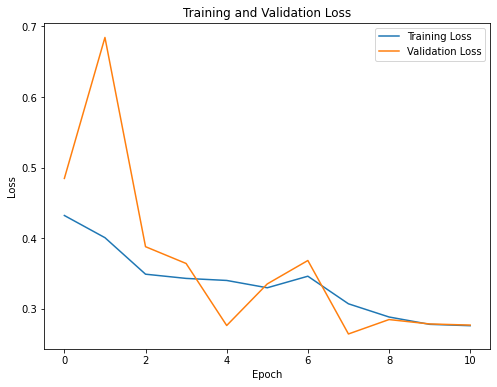

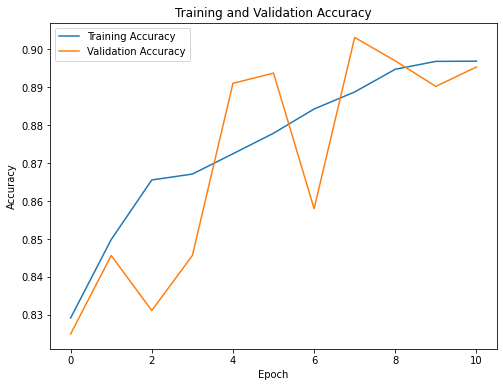

Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
loss number does not decrease =>  2e-05
Epoch [12/15], Train Loss: 0.2753, Val Loss: 0.2679, Train Acc: 0.8957, Val Acc: 0.9042


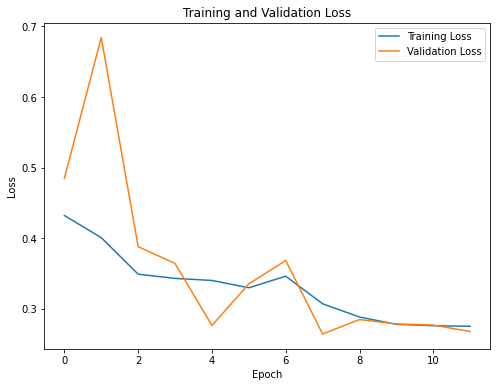

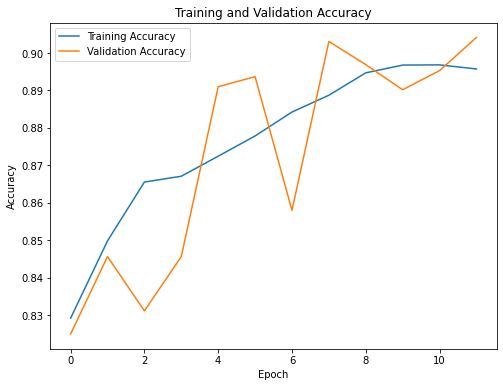

loss number does not decrease =>  2e-05
Epoch [13/15], Train Loss: 0.2672, Val Loss: 0.2756, Train Acc: 0.8976, Val Acc: 0.8974


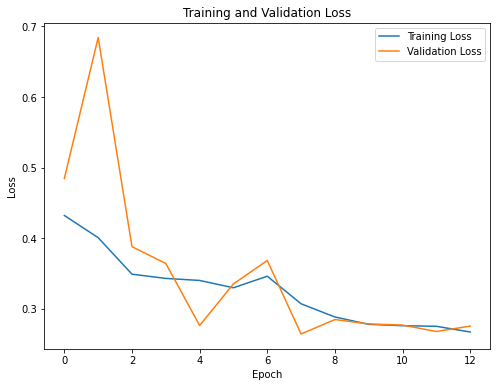

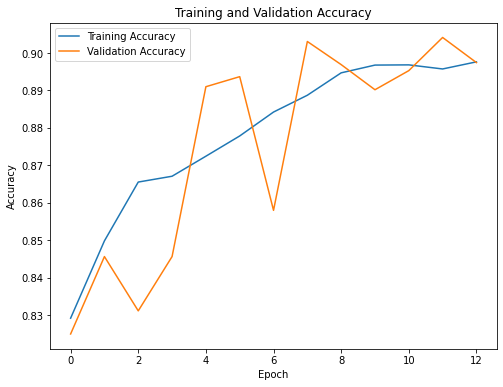

loss number does not decrease =>  2e-05
Epoch [14/15], Train Loss: 0.2668, Val Loss: 0.2626, Train Acc: 0.8978, Val Acc: 0.8993


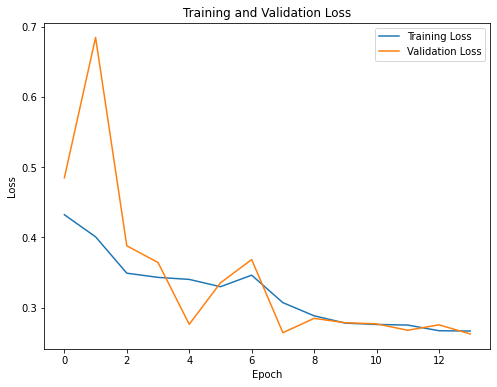

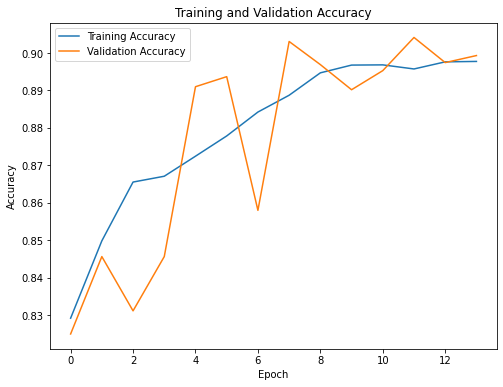

loss number does not decrease =>  2e-05
Epoch [15/15], Train Loss: 0.2664, Val Loss: 0.2698, Train Acc: 0.8982, Val Acc: 0.8991


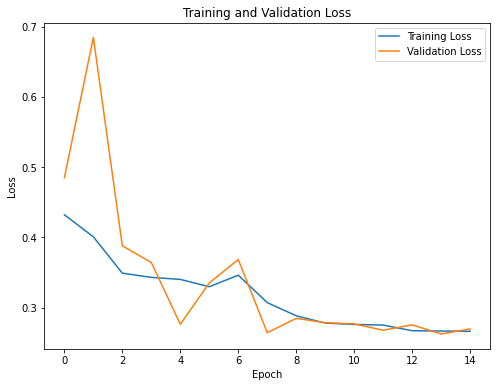

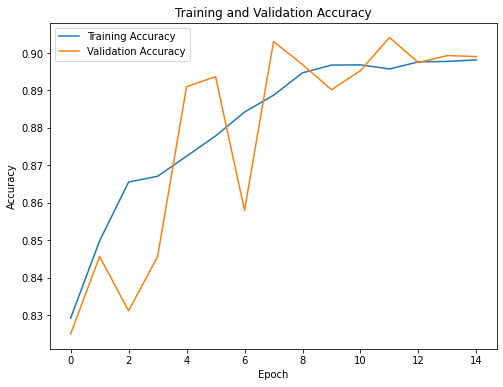

loss number does not decrease =>  2e-05
Epoch [16/15], Train Loss: 0.2666, Val Loss: 0.2759, Train Acc: 0.8987, Val Acc: 0.9004


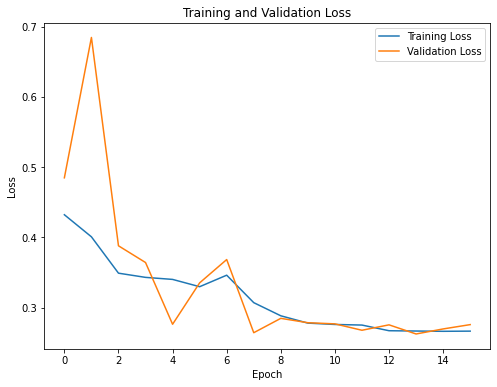

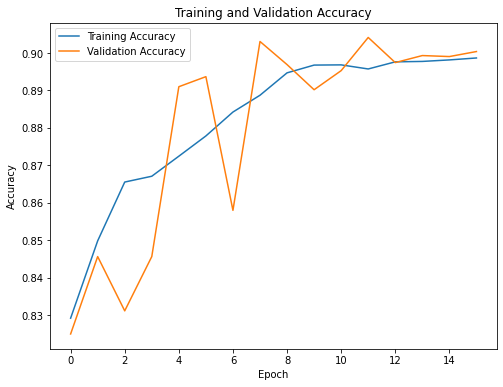

loss number does not decrease =>  2e-05
Epoch [17/15], Train Loss: 0.2621, Val Loss: 0.2826, Train Acc: 0.8991, Val Acc: 0.8974


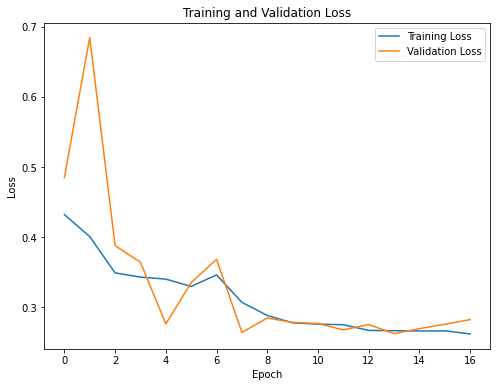

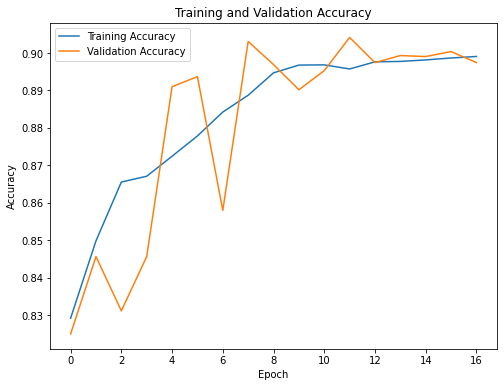

loss number does not decrease =>  2e-05
Epoch [18/15], Train Loss: 0.2649, Val Loss: 0.2776, Train Acc: 0.8987, Val Acc: 0.8926


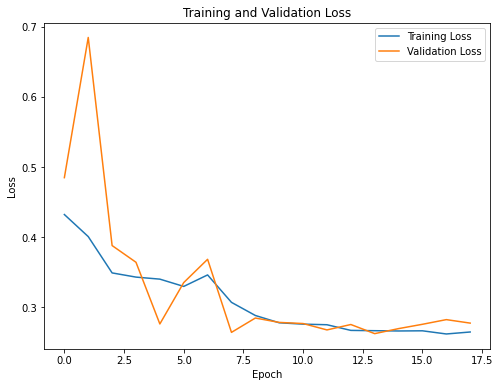

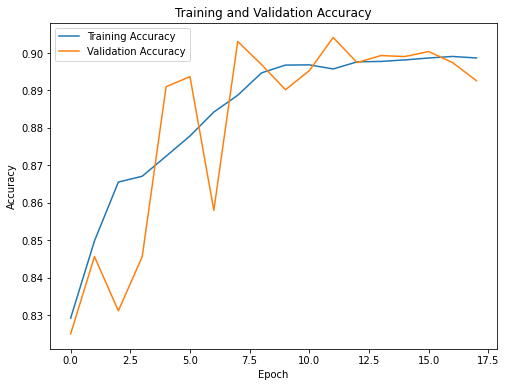

Epoch 00019: reducing learning rate of group 0 to 2.0000e-06.
loss number does not decrease =>  2.0000000000000003e-06
Epoch [19/15], Train Loss: 0.2605, Val Loss: 0.2548, Train Acc: 0.9001, Val Acc: 0.9026


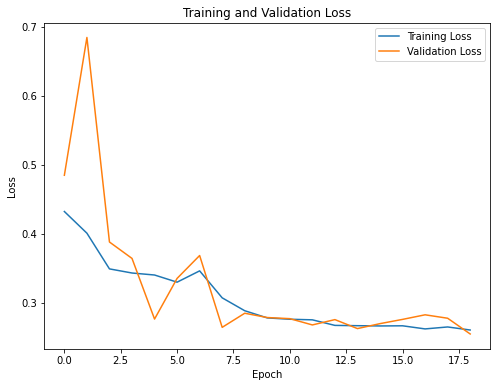

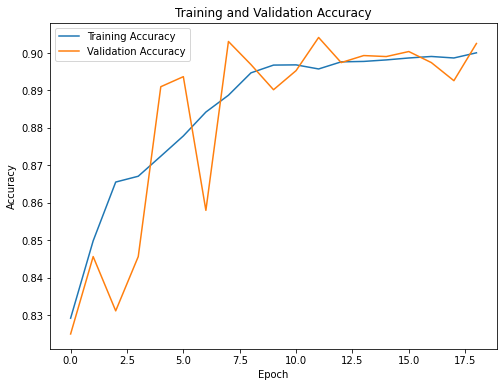

loss number does not decrease =>  2.0000000000000003e-06
Epoch [20/15], Train Loss: 0.2609, Val Loss: 0.2619, Train Acc: 0.9003, Val Acc: 0.9007


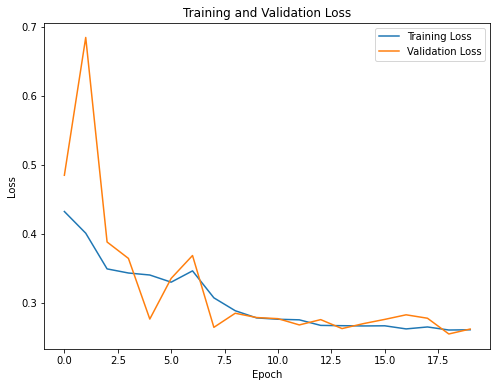

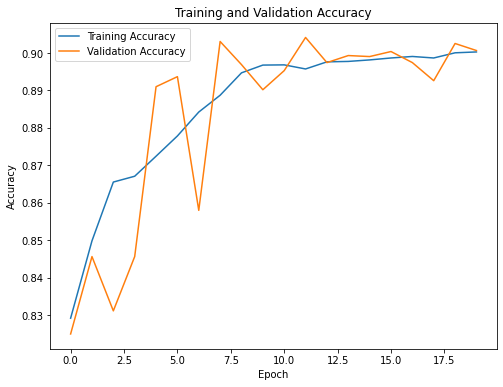

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

learning_rate = 0.002
# định nghĩa loss function
criterion = nn.BCEWithLogitsLoss()

# train model
optimizer = optim.Adam(model_rs.parameters(), lr=learning_rate, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


#def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rs.to(device)
    
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(20):
    train_loss, val_loss = 0, 0
    train_correct, val_correct = 0, 0
    train_total, val_total = 0, 0
        
        # training loop
    model_rs.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        #optimizer.zero_grad()
        outputs = model_rs(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == torch.max(labels, 1)[1]).sum().item()
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accs.append(train_correct / train_total)
    scheduler.step(loss) 
    print("loss number does not decrease => ",optimizer.param_groups[0]['lr'])
        # validation loop
    model_rs.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_rs(images)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == torch.max(labels, 1)[1]).sum().item()
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accs.append(val_correct / val_total)
    acc = val_correct / val_total
    if acc < 0.75:
      optimizer.param_groups[0]['lr'] *= 0.1
      print("acc < 0.75 => ",optimizer.param_groups[0]['lr'])
        # print the training and validation accuracy and loss for each epoch
    print(f"Epoch [{epoch+1}/{15}], Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")
        
        # plot the training and validation loss
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    plt.show()
        
        # plot the training and validation accuracy
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_accs, label='Training Accuracy')
    ax.plot(val_accs, label='Validation Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Validation Accuracy')
    ax.legend()
    plt.show()
        
        # step the scheduler


In [ ]:
torch.save(model_rs, 'model_rs.pkl')

In [ ]:
cnn = torch.load('model_rs.pt')

In [ ]:
from sklearn import metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rs.to(device)
    
y_pred = []
y_true = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(torch.max(labels, 1)[1].cpu().numpy())

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

precision = metrics.precision_score(y_true, y_pred, average=None)
recall = metrics.recall_score(y_true, y_pred, average=None)
f1_score = metrics.f1_score(y_true, y_pred, average=None)

print("Confusion Matrix:\n", confusion_matrix)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Confusion Matrix:
 [[1564  295]
 [  75 1791]]
Precision:  [0.95424039 0.85858102]
Recall:  [0.84131253 0.95980707]
F1 Score:  [0.89422527 0.90637652]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rs.to(device)

test_loss = 0
test_correct = 0
test_total = 0

model_rs.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_rs(images)
        loss = criterion(outputs, labels.float())
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == torch.max(labels, 1)[1]).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Test Loss: 0.2669, Test Acc: 0.8897
